In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import uniform
from scipy.integrate import quad

In [2]:
# "IMPLICIT" SEARCH FUNCTION
###########################################################################

def uij(ki,gammai,Vj,t,kj):
    """Utility patient i receives from doctor j"""

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
        
def aij(u,λ):
    """Intermediate function to calculate sij"""

    return np.where(u > 0, np.exp(λ*u), 0)
                
def logit_search(ki,gammai,Vj,t,kj,λ):    
    """Probability that patient i visits doctor j"""
    #It takes the J-sized vectors of all doctors' Vj and κj as arguments

    u = uij(ki,gammai,Vj,t,kj)
    ai_total = np.sum(aij(u,λ), axis = 0)

    with np.errstate(divide='ignore', invalid='ignore'):
        # To avoid pesky division by zero warning      
        return np.where(ai_total != 0, aij(u,λ)/ai_total, 0)


# Some auxiliary functions to set up chain rule derivatives

def dlogit_search_dk(ki,gammai,Vj,t,kj,λ):
    """Derivative d sij / d k"""

    u = uij(ki,gammai,Vj,t,kj)

    if np.sum(aij(u,λ)) == 0:
        return 0
    
    return np.divide(
        Vj * aij(u,λ) * np.sum(aij(u,λ))- aij(u,λ) * np.sum(Vj * aij(u,λ)),
        (np.sum(aij(u,λ)))**2
        )


The function 'sij' gives us each patient's Si vector of strategies, and if broadcast correctly it can output all patients' strategies in a single array (given numerable patients in a MC simulation), where each column is each patient’s Si, each row could be added up to a doctor's Qi.

We keep it as a callable function for cases where we want the sij of a particular set of patient x doctor parameters, namely when calculating the derivative of our FOC.

In [3]:
class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.λ, self.R, self.P, self.V, self.sij = I, F, G, t, λ, R, P, V, sij     # Save parameters
    
    def Si(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V, sij = self.I, self.F, self.G, self.t, self.λ, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
        kj = k0.reshape((-1,1))

        return sij(ki,gammai,Vj,t,kj,λ)

    def Qi(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.Si(k0, s)

        return np.sum(S, axis = 1)
    
    def Xi(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.Si(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def aux_func(self, func, k0):
        """Vector of int func(k0,gamma) dG(gamma) f(k0)"""

        # We will use this function both for func = sij as well as func = ds_dk

        F, G, t, λ, V = self.F, self.G, self.t, self.λ, self.V    # Unpack parameters

        f = lambda x: F.pdf(x)  # Taking pdfs of our κ and γ distributions
        g = lambda x: G.pdf(x)

        s_gamma = lambda x: np.diagonal(func(k0.reshape(1,-1),x,V,t,k0,λ)) 
        # Evaluate sij at each doctor's κj, then take the diagonal, taking doctor j's sij for his own kj
        # This is a lambda function for a given value of γ

        gamma_integrand = lambda x: s_gamma(x) * g(x) # sij(γ) g(γ)

        n = 101
        x = np.linspace(G.ppf(0),G.ppf(1),n) # n-sized linspace across the domain of G

        results = []

        # Loop that evaluates sij(γ) g(γ) for 101 values of γ
        for i in x:
            result = gamma_integrand(i)
            results.append(result)

        results = np.array(results)

        mc_integral = np.sum(results, axis = 0)/n
        # By summing column wise divided by n we get a monte-carlo approximation of an integral

        return - mc_integral * f(k0.reshape(-1,))
    
    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)

        return (dR(Q) - dP(X))*dQ_dk
    
    def dFOC_dk(self, k0, dR, dP, d2R, d2P, ds, df, s=123): #For now, we manually input the derivatives and second derivatives of interest

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)
        d2Q_dk = self.aux_func(ds, k0) + self.aux_func(sij, k0) * df(Q) # Double derivative of Q over κ

        return (dR(Q) - dP(X))*d2Q_dk + (d2R(Q) - d2P(X))*dQ_dk
        





In [4]:
# Number of doctors and patients
I = 100
J = 50

b = 5

F = expon(scale=1/b)
G = uniform
H = uniform(scale = 1)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H

r = 2
p = 1

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 0.1

In [5]:
rng = np.random.RandomState(123)
ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))

V =  np.sort(V)
Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
kj = k0.reshape((-1,1))
Vj = np.sort(Vj)

In [6]:
J = 2
V = H.rvs(size=J, random_state=rng)
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, logit_search)

In [7]:
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x, y)

# Flatten the grids and stack them as 1x2 vectors
XY = np.stack([X.ravel(), Y.ravel()], axis=1)

func = lambda x: LogitModel.FOC(x, dR, dP)[0]

# Apply the function to each vector
Z = np.apply_along_axis(func, 1, XY).reshape(X.shape)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of func([x, y])')
plt.show()


KeyboardInterrupt: 

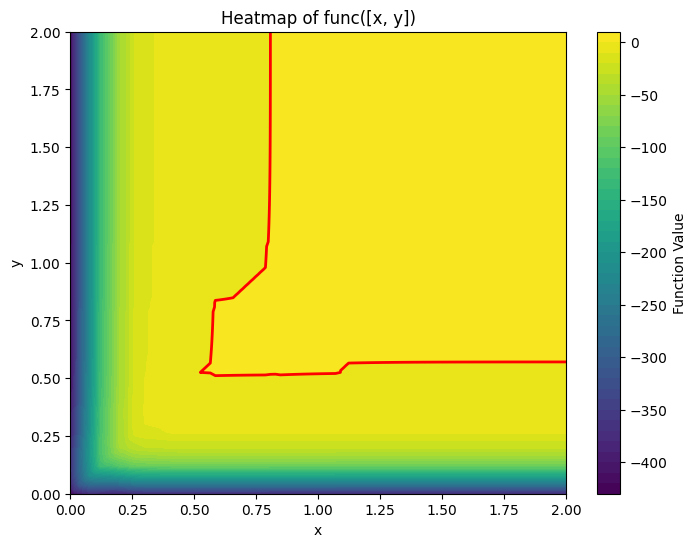

In [ ]:
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x, y)

# Flatten the grids and stack them as 1x2 vectors
XY = np.stack([X.ravel(), Y.ravel()], axis=1)

func2 = lambda x: np.sum(LogitModel.FOC(x, dR, dP))

# Apply the function to each vector
Z = np.apply_along_axis(func2, 1, XY).reshape(X.shape)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of func([x, y])')
plt.show()

In [ ]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, logit_search)

array([14.1842916 , 13.06083275, 12.97163631, 12.73993546, 12.71222631,
       11.42308408, 11.4172476 ,  8.44315981,  5.53770117,  5.51121995,
        5.44644248,  5.42891114,  5.40912331,  5.33868135,  4.16021935,
        2.26380686,  2.01066349,  1.76900044,  1.4040796 ,  1.1324181 ,
        1.13194778,  1.1278828 ,  1.00984447,  0.90586063,  0.72569406,
        0.72468746,  0.71961868,  0.60240016,  0.49405987,  0.45192782,
        0.45189493,  0.43474151,  0.39891047,  0.39885077,  0.38936854,
        0.38927374,  0.38922794,  0.38442722,  0.38439089,  0.38368112,
        0.38367692,  0.3836741 ,  0.38366768,  0.38344326,  0.38323324,
        0.38320937,  0.38319198,  0.38317605,  0.38316473,  0.38316322])

In [ ]:
f = lambda x: LogitModel.FOC(x, dR, dP)
Df = lambda x: LogitModel.dFOC_dk(x, dR, dP, d2R, d2P, dlogit_search_dk, df)

In [8]:
def newton(f, Df, x_0, tol=1e-7, max_iter=100_000):     # As seen in QuantEcon
    x = x_0

    # Implement the zero-finding formula
    def q(x):
        Df_x = Df(x)  # Compute Df(x) once to avoid redundant calculations
        return np.where(Df_x == 0, 0, x - f(x) / Df_x)

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y = q(x)
        error = np.abs(x - y)
        
        x = y
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x)

In [ ]:
def NAG(Df, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x)

In [ ]:
k_guess = 0.2*np.ones(J)
k, error, dK = NAG(Df, k_guess, tol=1e-4, max_iter=1000, alpha = 0.01, beta = 0.9)
k

Convergence not acheived, max iterations


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.51800613, 2.77501664, 2.76828235,
       2.77232373, 2.77502686, 2.77004623, 2.7650651 , 2.80950507,
       2.52020855, 2.45444119, 2.36694513, 2.26362365, 2.15937928,
       2.15919542, 2.15760412, 2.12478924, 2.09467149, 1.99347473,
       1.99290829, 1.99036286, 1.93390689, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
LogitModel.Qi(k)

array([3.97294235, 3.96293661, 3.39047874, 3.2950096 , 3.24638299,
       3.01878836, 2.51371823, 2.50061253, 2.49393067, 2.49101497,
       2.48671599, 2.45393044, 2.43764013, 2.21960103, 2.21516495,
       2.20611653, 2.19199979, 2.18962695, 1.95526874, 1.93274419,
       1.93242801, 1.91869918, 1.89890664, 1.8482619 , 1.83666007,
       1.83438397, 1.64364947, 1.56869246, 1.56589564, 1.52881725,
       1.5283109 , 1.52566788, 1.51767576, 1.50167114, 1.4128854 ,
       1.30535418, 1.28926772, 1.14803294, 1.14349044, 1.13948865,
       0.98865461, 0.93899657, 0.87202448, 0.79670043, 0.77617801,
       0.56433257, 0.50794503, 0.15028392, 0.1184257 , 0.02359528])